In [59]:
import rasterio
from rasterio.io import MemoryFile
import numpy as np
from matplotlib import pyplot as plt
import time
import datetime

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
zoom = 5

coords_top_left = [14*(2**(zoom-5)), 7*(2**(zoom-5))]
    
if zoom>5:
    coords_bottom_right = [19*(2**(zoom-5))+1, 12*(2**(zoom-5))+1] 
else:
    coords_bottom_right = [19*(2**(zoom-5)), 12*(2**(zoom-5))]
    
tiles_x = abs(coords_top_left[0]-coords_bottom_right[0])
tiles_y = abs(coords_top_left[1]-coords_bottom_right[1])

def generate_zoom_tiles():
    zoom_tiles = []
    
    for x in range(coords_top_left[0],coords_bottom_right[0]):
        for y in range(coords_top_left[1],coords_bottom_right[1]):
            zoom_tiles.append("s3://elevation-tiles-prod/geotiff/"+str(zoom)+"/"f"{x}/{y}.tif")
    return zoom_tiles

def unravel_data(byte):
    with MemoryFile(byte) as memfile:
        with memfile.open() as dt:
            data_arr = dt.read()
            return data_arr

def remove_water(data_dist_array):
    #val = data_dist_array[0]
    np.place(data_dist_array, data_dist_array<0, 0)
    return data_dist_array

        
def get_mean_value(data_dist_array):
    val = data_dist_array[0]
    TILE_SIZE=512
    SUB_TILE_SIZE=4*(2**(zoom-5))
    print(SUB_TILE_SIZE)
    if val.shape[0] != TILE_SIZE:
        SUB_TILE_SIZE = int(SUB_TILE_SIZE // (TILE_SIZE//val.shape[0]))
    tile = val.reshape(TILE_SIZE//SUB_TILE_SIZE, SUB_TILE_SIZE, -1, SUB_TILE_SIZE).swapaxes(1, 2).reshape(-1, SUB_TILE_SIZE, SUB_TILE_SIZE)
    #raise TypeError(f"hehe: {val.shape}")
    #if tile.shape != (16, 128, 128):
    #    raise TypeError(f"hehe: {val.shape}") #to zobaczymy co zwroci shape, i bedziemy chcieli sprawdzac czy sie zgadza wspolrzedna
    #return tile
    #lows = np.amin(tile, axis=(1, 2))
    #highs = np.amax(tile, axis=(1, 2))
    #deltas = highs-lows
    deltas = np.mean(np.mean(np.abs(np.gradient(tile, axis=(1,2))), axis=0), axis=(1,2))
    #deltas = np.mean(np.mean(np.abs(np.gradient(tile, axis=(1,2))), axis=0), axis=(1,2)).flatten()
#    if deltas.size != (TILE_SIZE//SUB_TILE_SIZE)**2:
#        return np.ones((TILE_SIZE//SUB_TILE_SIZE, TILE_SIZE//SUB_TILE_SIZE))*10000
#        deltas = np.repeat(deltas, ((TILE_SIZE//SUB_TILE_SIZE)**2)/deltas.size)
    return deltas.reshape((val.shape[0]//SUB_TILE_SIZE, val.shape[0]//SUB_TILE_SIZE))
    #return deltas

def digitize_tiles(data_dist_array, bins):
    return np.digitize(data_dist_array, bins)

def get_min_val(data_dist_array):
    return np.min(data_dist_array)

def get_max_val(data_dist_array):
    return np.max(data_dist_array)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
zoom_tiles = generate_zoom_tiles()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
time1 = time.time()
data_dist = sc.binaryFiles(",".join(zoom_tiles))
data_dist_values = data_dist.map(lambda x: bytes(x[1]))
data_dist_array = data_dist_values.map(lambda x: unravel_data(x))
data_dist_nowater = data_dist_array.map(lambda x: remove_water(x))
data_dist_deltas = data_dist_nowater.map(lambda x: get_mean_value(x))
data_dist_min = min(data_dist_deltas.map(lambda x: get_min_val(x)).collect())
data_dist_max = max(data_dist_deltas.map(lambda x: get_max_val(x)).collect())

bins = np.geomspace(10, data_dist_max+1, 6)

data_dist_digitized = data_dist_deltas.map(lambda x: digitize_tiles(x, bins))
tiles_digitized = data_dist_digitized.collect()

map_rows=[]

for y in range(tiles_x):
    map_rows.append(np.vstack(tiles_digitized[y*tiles_y:y*tiles_y+tiles_y]))

map_all = np.hstack(map_rows)

time2 = time.time()
koniec_o_godzinie = datetime.datetime.now()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
bins2 = np.linspace(10, data_dist_max+1, 6)
data_dist_digitized2 = data_dist_deltas.map(lambda x: digitize_tiles(x, bins2))
tiles_digitized2 = data_dist_digitized2.collect()
map_rows2=[]

for y in range(tiles_x):
    map_rows2.append(np.vstack(tiles_digitized2[y*tiles_y:y*tiles_y+tiles_y]))

map_all2 = np.hstack(map_rows2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
czas = time2-time1

print(czas)
print(koniec_o_godzinie)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6.544110536575317
2021-02-08 19:59:16.529322

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

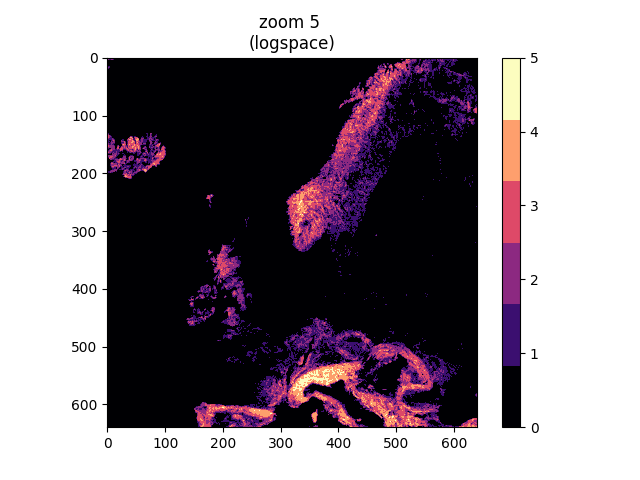

In [66]:
plt.close()
cmap = plt.cm.get_cmap("magma", len(bins))
fig = plt.figure() 
im = plt.imshow(map_all, cmap=cmap) 
plt.title(f"zoom {zoom} \n(logspace)")
fig.colorbar(im) 

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

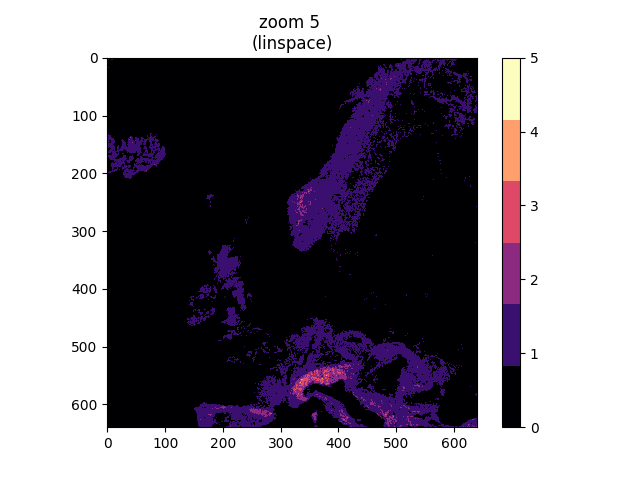

In [69]:
plt.close()
fig = plt.figure() 
im2 = plt.imshow(map_all2, cmap=cmap) 
plt.title(f"zoom {zoom} \n(linspace)")
fig.colorbar(im2) 

%matplot plt